In [1]:
!rm stan_utility.py

!wget https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py

--2019-07-23 15:14:28--  https://raw.githubusercontent.com/betanalpha/jupyter_case_studies/master/pystan_workflow/stan_utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.120.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.120.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5593 (5.5K) [text/plain]
Saving to: ‘stan_utility.py’

stan_utility.py     100%[===================>]   5.46K  --.-KB/s    in 0s      

2019-07-23 15:14:28 (24.7 MB/s) - ‘stan_utility.py’ saved [5593/5593]



In [2]:
%matplotlib inline

import random
random.seed(123)

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import importlib

In [3]:
import pystan
import stan_utility

import survivalstan

## SurvivalStan - Exponential Model

Tutorial:
http://www.hammerlab.org/2017/06/26/introducing-survivalstan/

### Model 1: Exponential model with no covariates

$S(t) = exp(-a \cdot t)$

$a \sim N(0,1)$

In [ ]:
# Data
df1 = survivalstan.sim.sim_data_exp(censor_time = 50, 
                                    N = 2000, 
                                    rate = 0.35)

df1['event_fac'] = df1['event'].apply(lambda x: 1 if x == True else 0)

data1 = dict(N = len(df1),
            y = df1['t'],
            event = df1['event_fac'])

survivalstan.utils.plot_observed_survival(df1, time_col='t', event_col='event')

df1.head(n = 5)

In [ ]:
# Compile model
model = stan_utility.compile_model('exp.stan')

In [ ]:
# Infer parameters
Niter = 10000
Nchains = 2

ctrl = {'max_treedepth': 20,
        'adapt_delta': 0.99}

fit = model.sampling(data = data1, 
                     chains = Nchains,
                     iter = Niter,
                     control = ctrl,
                     seed = 194838)

In [ ]:
pystan.check_hmc_diagnostics(fit)

In [ ]:
fit

### Model 2: Exponential model with covariates

$S(t) = exp(-a \cdot t) \cdot exp(-beta \cdot X)$

$a \sim N(0,1)$

$b \sim $

,sex,age,rate,true_t,t,event,index,event_fac,sex_fac
0,female,62,0.049787,19.105065,19.105065,True,0,1,0
1,female,53,0.049787,18.748806,18.748806,True,1,1,0
2,female,70,0.049787,49.711349,20.000000,False,2,0,0
3,female,70,0.049787,8.553184,8.553184,True,3,1,0
4,female,51,0.049787,13.939467,13.939467,True,4,1,0


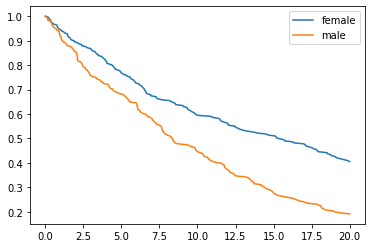

In [4]:
# Data
df2 = survivalstan.sim.sim_data_exp_correlated(N = 500, 
                                               censor_time = 20, 
                                               rate_form = '1 + sex', 
                                               rate_coefs=[-3, 0.5])

# Convert dummies
# event status (1:event, 0:censor) for obs n
df2['event_fac'] = df2['event'].apply(lambda x: 1 if x == True else 0)
df2['sex_fac'] = df2['sex'].apply(lambda x: 1 if x == 'male' else 0)

# Prepare data input dict
data2 = dict(N = len(df2),
             M = 2,
             x = df2[['age', 'sex_fac']].to_numpy(),
             y = df2['t'],
             event = df2['event_fac'])

# Plot data
from matplotlib import pyplot as plt
survivalstan.utils.plot_observed_survival(
    df2.query('sex == "female"'),
    time_col='t',
    event_col='event',
    label='female')
survivalstan.utils.plot_observed_survival(
    df2.query('sex == "male"'),
    time_col='t',
    event_col='event',
    label='male')
plt.legend()

# Show data
df2.head()

##### Raw stan

In [ ]:
# Compile model
model = stan_utility.compile_model('exp_covar.stan')

In [ ]:
# Infer parameters
Niter = 5000
Nchains = 4

ctrl = {'max_treedepth': 20,
        'adapt_delta': 0.99}

fit = model.sampling(data = data2, 
                     chains = Nchains,
                     iter = Niter,
                     control = ctrl,
                     seed = 194838)

In [ ]:
fit

##### Survivalstan

In [ ]:
# Model org
ctrl = dict(adapt_delta = 0.99,
            max_treedepth = 20)

fit2_org = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex',
    model_cohort = 'exp model',
    iter = 5000,
    chains = 4,
    warmup = 4500,
    control = ctrl)

Reusing model.


In [6]:
survivalstan.utils.filter_stan_summary([fit2_org], pars=['lp__','beta'])

,mean,se_mean,sd,2.5%,50%,97.5%,Rhat
lp__,-2.229614e+196,NaN,inf,-2.308498e+197,-2.732371e+13,-1318.645649,NaN
beta[1],7.842611e+00,7.144863,10.129983,3.584602e-01,3.055654e+00,25.047511,135.222142
beta[2],1.491519e+00,1.826986,2.590248,-2.082861e-02,5.837197e-04,5.991533,395.048544


In [7]:
sfit2_org = fit2_org['fit']
sfit2_org

/Users/arnoldp9/Projects/exp_survivalstan/env/lib/python3.7/site-packages/numpy/core/_methods.py:122: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)



For the full summary use 'print(fit)'

Inference for Stan model: anon_model_0176fed484efbd961d78e8973c25ff98.
4 chains, each with iter=500; warmup=400; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tau_s_raw     2.43    1.79   2.56   0.03   0.33   2.05    4.6   6.67      2   8.39
tau_raw[1]   21.27    8.77 118.38   0.29   1.71   3.43   3.74 130.72    182   1.02
tau_raw[2]     2.6    1.39   3.88   0.19   0.22   0.79   5.72   9.08      8   1.22
beta_raw[1]   1.49    0.31   0.64   0.16   0.91   1.94   1.95   2.28      4   1.54
beta_raw[2]   0.31    0.37   0.53   -0.1-4.1e-3 1.2e-3    0.9   1.21      2   8.61
alpha         0.35    0.26   0.38   0.03   0.05   0.23   0.68   0.97      2  29.26
beta[1]       7.84    7.14  10.13   0.36   0.53   3.06  16.14  25.05      2 135.22
beta[2]       1.49    1.83   2.59  -0.02-3.1e-3 5.8e-4   3.29   5.99      2 395.05
lp[1]      2.3e160     nan  

In [9]:
pystan.check_hmc_diagnostics(sfit2_org)

{'n_eff': False,
 'Rhat': False,
 'divergence': False,
 'treedepth': True,
 'energy': False}

In [ ]:
fit2_org['data']


In [ ]:
# Simulate data
# Model: exp(-3*t) * exp(0.5*sex)

# Sim
df2 = survivalstan.sim.sim_data_exp_correlated(
    N=500, censor_time=20, rate_form='1 + sex', rate_coefs=[-3, 0.5])

# Replace strings
df2['sex_fac'] = df2['sex'].apply(lambda x: 1 if x == 'male' else 0)
df2['event_fac'] = df2['event'].apply(lambda x: 1 if x == 'True' else 0)

# Write to file
df2.to_csv('exp.dat')

# Prepare data input
x = df2[['age', 'sex_fac']].to_numpy()

data = dict(N = len(df2),
            M = 2,
            x = x,
            y = df2['t'],
            event = df2['event_fac'])

In [ ]:
df2.head()

In [ ]:
survivalstan.utils.plot_observed_survival(
    df2.query('sex_fac == 1'),
    time_col='t',
    event_col='event_fac',
    label='female: 1')

survivalstan.utils.plot_observed_survival(
    df2.query('sex_fac == 0'),
    time_col='t',
    event_col='event_fac',
    label='male: 0')

plt.legend()

In [ ]:
# Model used
src_model = survivalstan.models.exp_survival_model

with open('exp.stan', 'w') as myf:
    print(src_model, file = myf)
    
print(src_model)

In [ ]:
# Compile model
model = stan_utility.compile_model('exp.stan')

In [ ]:
# Infer parameters
Niter = 10000
Nchains = 2

ctrl = {'max_treedepth': 20,
        'adapt_delta': 0.99}

fit = model.sampling(data = data, 
                     chains = Nchains,
                     iter = Niter,
                     # warmup = 9000,
                     control = ctrl,
                     seed=194838)

pystan.check_hmc_diagnostics(fit)

In [ ]:
fit

In [ ]:
# Infer parameters
fit1 = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex',
    model_cohort = 'exp model',
    iter = Niter,
    chains = Nchains,    
    seed = 194838
)

In [ ]:
sfit1 = fit1['fit']
sfit1

In [ ]:
fit2 = survivalstan.fit_stan_survival_model(
    df=df2,
    time_col='t',
    event_col='event_fac',
    model_code=survivalstan.models.exp_survival_model,
    formula='~ age + sex_fac',
    model_cohort = 'exp model fac',
    iter = Niter,
    chains = Nchains,    
    seed = 194838
)

In [ ]:
sfit2 = fit2['fit']


In [ ]:
# Some results
survivalstan.utils.filter_stan_summary([fit1], pars=['lp__','beta'])

survivalstan.utils.plot_coefs([fit1, fit2])

In [ ]:
pystan.check_hmc_diagnostics(fit1['fit'])

In [ ]:
# Diagnostics - tutorial
survivalstan.fit_stan_survival_model

In [ ]:
# Diagnostics
# http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

sfit1 = fit1['fit']
stan_utility.check_all_diagnostics(sfit1)

In [ ]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility.partition_div(sfit1)

plt.scatter([x[0] for x in nondiv_params['beta']], [x[1] for x in nondiv_params['beta']], 
             color = mid_highlight, alpha=0.1)

plt.scatter([x[0] for x in div_params['beta']], [x[1] for x in div_params['beta']], 
             color = green, alpha=0.25)